In [1]:
!pip install zeugma

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from zeugma.embeddings import EmbeddingTransformer


In [3]:
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords## 1. Load dataset

## 1. Load dataset

In [4]:
#For reading data, we have to put path of the csv data file.
df_t = pd.read_csv(r'C:\Users\kapil\OneDrive\Desktop\NLP_Uzair\Project\Reddit_Sarcasm_Detection-main\Reddit_Sarcasm_Detection-main\src\data\train-balanced-sarcasm.csv')
df_t = df_t.fillna('')
df_t = df_t[['label','comment','author','score','created_utc','parent_comment']]
df_t.head()

,label,comment,author,score,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,2,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,-4,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,3,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,-8,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,6,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
# df = pd.read_csv(r'C:\Users\kapil\OneDrive\Desktop\NLP_Uzair\Project\Reddit_Sarcasm_Detection-main\Reddit_Sarcasm_Detection-main\src\data\train-balanced-sarcasm.csv')
# df = df.fillna('')
# df = df[['label','comment','author','score','created_utc','parent_comment']]
# df.head()

,label,comment,author,score,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,2,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,-4,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,3,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,-8,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,6,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
#Loading GloVe
embeddings_index = {}
glove_path = r'C:\Users\kapil\OneDrive\Desktop\NLP_Uzair\Project\Reddit_Sarcasm_Detection-main\Reddit_Sarcasm_Detection-main\src\models\GlOVE\glove.6B.50d.txt'
with open(glove_path, encoding="utf8") as f:
    for line in tqdm(f):
        
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            pass
print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Found 400000 word vectors.


# Cleaning comments

In [7]:
#Set of stop words excluding some of the words which show negation since its necessary for sarcasm detection:
stops = set(stopwords.words('english')) - {'no','not','nor','against','above','below','off','own'}

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
def clean_text(comment):
    text = str(comment)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ',text)
    text = re.sub("<.*?>", " ", text)
    text = re.sub(r"[0-9]+"," ",text)
    text = re.sub(r"@[A-Za-z0-9]+"," ",text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\'t", ' not',text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+',' ', text)
    text = ' '.join(token for token in tokenizer.tokenize(text.lower()) if token not in stops)
    text = text.lower().strip()
    return text

df["cleaned_comment"] = df.swifter.apply(lambda x: clean_text(x["comment"]),axis=1)


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

# Train-test Split

In [8]:
train_x, val_x,train_y , val_y = train_test_split(df.drop('label',axis=1),df['label'],random_state=123,test_size=0.20)
train_txt = train_x['cleaned_comment']
val_txt = val_x['cleaned_comment']

# Create the embedded vectors for training and testing

In [9]:
#Converts sentence to vectors
def sent2vec(s):
    stop_words = set(stopwords.words("english"))
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

xtrain_glove50 = [sent2vec(x) for x in tqdm(train_txt)]
xval_glove50 = [sent2vec(x) for x in tqdm(val_txt)]

  0%|          | 0/808660 [00:00<?, ?it/s]

  0%|          | 0/202166 [00:00<?, ?it/s]

In [11]:
#Using pre trained word embedding
glove = EmbeddingTransformer('glove')

#Transforming data
xtrain_glove = glove.transform(train_txt)
xval_glove = glove.transform(val_txt)


# Logistic Regressing with  Glove

In [12]:
#Initializing logistic regression classifier
%%time
log_reg_glove = LogisticRegression(random_state=123,n_jobs=6,verbose=1,max_iter = 10000,solver = 'saga', C = 0.1)

#fitting model
log_reg_glove.fit(xtrain_glove,train_y)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


convergence after 17 epochs took 20 seconds
Wall time: 20.3 s


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   20.1s finished


LogisticRegression(C=0.1, max_iter=10000, n_jobs=6, random_state=123,
                   solver='saga', verbose=1)

In [13]:
#predicting values
%%time
val_predict = log_reg_glove.predict(xval_glove)

#Calculating accuracy
accuracy_score(val_y,val_predict)
#0.5749483098048138

Wall time: 64.9 ms


0.5749483098048138

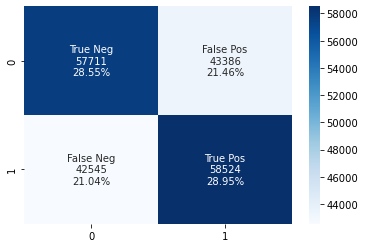

In [14]:
#Plotting confusion matrix for the same
def plot_conf_mat(val_y,val_predict):
    log_regression_conf_mat = confusion_matrix(val_y,val_predict)
    # sn.heatmap(log_regression_conf_mat, annot=True,cmap='Blues')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    log_regression_conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        log_regression_conf_mat.flatten()/np.sum(log_regression_conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(log_regression_conf_mat, annot=labels, fmt='', cmap='Blues')
plot_conf_mat(val_y,val_predict)

# RandomForest with Glove

In [15]:
#Initializing RandomForest Classifier
%%time
rf_glove = RandomForestClassifier(max_depth = 1000, n_estimators = 400, random_state = 123, n_jobs = 6, verbose = 1)

#fitting model
rf_glove.fit(xtrain_glove,train_y)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  6.5min


Wall time: 14min 14s


[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed: 14.2min finished


RandomForestClassifier(max_depth=1000, n_estimators=400, n_jobs=6,
                       random_state=123, verbose=1)

In [16]:
#predicting values
%%time
val_predict = rf_glove.predict(xval_glove)

#Calculating accuracy
accuracy_score(val_y,val_predict)
#0.6275733802914437

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   11.2s


Wall time: 22.6 s


[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:   22.2s finished


0.6275733802914437

## Decision Tree with Glove: 

In [17]:
#Initializing DecisionTree Classifier
%%time
dt_glove = tree.DecisionTreeClassifier(max_depth=256,criterion="entropy",splitter="random")

#fitting model
dt_glove.fit(xtrain_glove,train_y)

Wall time: 6.65 s


DecisionTreeClassifier(criterion='entropy', max_depth=256, splitter='random')

In [18]:
#predicting values
%%time
val_predict = dt_glove.predict(xval_glove)
#calculating accuracy
accuracy_score(val_y,val_predict)
#0.5641255206117745

Wall time: 145 ms


0.5641255206117745